# Models with data with LLE
- Models includes lasso, ridge, gradient boosting, bagging, svm, and xgboost.
- After training above models, we choose 3~5 models with best parameters to do stacking.
- We use 5-fold cross validation to ensure model robustness and avoid overfitting.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [1]:
import pandas as pd
import numpy as np

## Read dataset

In [2]:
data_train = pd.read_csv('trainset_w_lle.csv')
data_test = pd.read_csv('testset_w_lle.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time,previous_5_to_10MA,lle1,lle2
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00,32742.135802,0.007683,0.000329
1,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00,36014.925926,0.008566,0.006095
2,45909,0,Safeco Field,1,-1.842921,-1.281036,LAA,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/SEA/S...,2015-04-06 13:12:00,25485.604938,0.003695,0.009393
3,53518,0,Dodger Stadium,1,-0.804795,-1.281036,SDP,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/LAN/L...,2015-04-06 13:12:00,46695.518519,0.007517,0.002310
4,48469,0,Yankee Stadium III,1,-1.842921,-0.489072,TOR,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/NYA/N...,2015-04-06 13:13:00,42520.300000,0.006798,-0.005155


In [3]:
data_train.columns

Index(['attendance', 'is_federal_holiday', 'venue', 'on_grass', 'temperature',
       'wind_speed', 'team1_name', 'team1_pre_win', 'team1_pre_loss',
       'team1_pre_win_pct', 'team1_streak', 'team2_name', 'team2_pre_win',
       'team2_pre_loss', 'team2_pre_win_pct', 'team2_streak', 'salary-500-800',
       'salary-800-1500', 'salary-1500', 'day_Friday', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'month_April', 'month_August', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'weather_Cloudy', 'weather_Drizzle',
       'weather_In Dome', 'weather_Overcast', 'weather_Rain', 'weather_Sunny',
       'season_type', 'season', 'home_team_avg_att_last_year', 'start_hour',
       'start_hour_label_afternoon', 'start_hour_label_evening',
       'start_hour_label_night', 'start_hour_label_noon', 'game_page_url',
       'start_time', 'previous_5_to_10MA', 'lle

## Data processing

In [4]:
from sklearn.preprocessing import StandardScaler
# standardize
number_col = ['previous_5_to_10MA']

# Standardize features by removing the mean and scaling to unit variance.
xscaler = StandardScaler().fit(data_train[number_col])
#standardize feature values
data_train[number_col] = xscaler.transform(data_train[number_col])
data_test[number_col] = xscaler.transform(data_test[number_col])

In [5]:
data_train.drop(['venue', 'wind_speed', 'start_hour', 'start_time', 'game_page_url'], axis=1, inplace=True)
data_test.drop(['venue', 'wind_speed', 'start_hour', 'start_time', 'game_page_url'], axis=1, inplace=True)

In [6]:
data_train = pd.get_dummies(data_train, columns=['team1_name', 'team2_name', 'season_type'])
data_test = pd.get_dummies(data_test, columns=['team1_name', 'team2_name', 'season_type'])

In [7]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [8]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()
set()


In [9]:
data_train.columns

Index(['attendance', 'is_federal_holiday', 'on_grass', 'temperature',
       'team1_pre_win', 'team1_pre_loss', 'team1_pre_win_pct', 'team1_streak',
       'team2_pre_win', 'team2_pre_loss',
       ...
       'team2_name_SDP', 'team2_name_SEA', 'team2_name_SFG', 'team2_name_STL',
       'team2_name_TBR', 'team2_name_TEX', 'team2_name_TOR', 'team2_name_WSN',
       'season_type_post', 'season_type_regular'],
      dtype='object', length=108)

In [10]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [11]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 107)


## Lasso
### Hyperparameters Tuning

In [12]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
# use grid search to find the best alpha
alphas = np.logspace(-3, 3, 20)
print(alphas)

[1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
model = Lasso(max_iter=50000)
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=50000),
             param_grid={'alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: Lasso(alpha=1.438449888287663, max_iter=50000)
Best parameters: {'alpha': 1.438449888287663}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,58.227916,2.243695,0.001326,0.000417,0.001,{'alpha': 0.001},-2.629589e+07,-2.788178e+07,-2.728938e+07,-2.645784e+07,...,48.467645,11,-0.162984,-0.16282,-0.160831,-0.160847,-0.152209,-0.159938,0.003974,1
1,62.520946,2.314863,0.001830,0.000381,0.002069,{'alpha': 0.00206913808111479},-2.629579e+07,-2.788180e+07,-2.728923e+07,-2.645791e+07,...,48.467030,10,-0.162984,-0.16282,-0.160831,-0.160847,-0.152209,-0.159938,0.003974,2
2,57.498987,2.466145,0.001405,0.000497,0.004281,{'alpha': 0.004281332398719396},-2.629557e+07,-2.788183e+07,-2.728888e+07,-2.645809e+07,...,48.466316,9,-0.162985,-0.16282,-0.160830,-0.160848,-0.152209,-0.159938,0.003974,3
3,54.795339,4.691787,0.001361,0.000479,0.008859,{'alpha': 0.008858667904100823},-2.629514e+07,-2.788189e+07,-2.728831e+07,-2.645848e+07,...,48.466232,8,-0.162986,-0.16282,-0.160828,-0.160849,-0.152208,-0.159938,0.003974,4
4,30.811924,6.547118,0.001616,0.000841,0.01833,{'alpha': 0.018329807108324356},-2.629423e+07,-2.788204e+07,-2.728702e+07,-2.645926e+07,...,48.464237,7,-0.162989,-0.16282,-0.160825,-0.160850,-0.152208,-0.159939,0.003975,5


### Train with best params

In [41]:
model = Lasso(max_iter=50000, alpha=1.438449888287663)
model = model.fit(x_train, y_train)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = model.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 26156460.43719666
Train RMSE: 5114.338709666838
Train MAE: 3935.5458952700133
Train MAPE: 0.15879753712033354


In [43]:
# print top 10 features with the highest coefficients
coef = pd.Series(model.coef_, index = data_train.columns)
print("top 10 features with the highest coefficients:\n", coef.sort_values(ascending=False)[:10])

top 10 features with the highest coefficients:
 day_Saturday          6398.683193
season_type_post      4635.083864
day_Friday            4044.812025
team2_name_LAD        3963.886950
month_March           3614.915726
team1_name_NYY        3474.626943
team1_name_CHC        3374.170431
day_Sunday            3337.240954
previous_5_to_10MA    3321.409872
team2_name_LAA        3074.053249
dtype: float64


In [44]:
# also print the top 10 features with the lowest coefficients
print("top 10 features with the lowest coefficients:\n", coef.sort_values(ascending=False)[-10:])

top 10 features with the lowest coefficients:
 month_October       -2583.551031
team2_name_OAK      -2645.695210
team2_name_PIT      -2739.570537
team2_name_CLE      -2974.929695
team2_pre_loss      -3126.449860
month_September     -3185.055110
team2_name_MIA      -3806.704790
team2_name_TBR      -4058.345862
team2_pre_win_pct   -5002.602362
team1_pre_win_pct   -6809.265481
dtype: float64


In [45]:
# print top 10 features with the highest coefficients with absolute value
print("top 10 features with the highest coefficients with absolute value:\n", coef.abs().sort_values(ascending=False)[:10])

top 10 features with the highest coefficients with absolute value:
 team1_pre_win_pct    6809.265481
day_Saturday         6398.683193
team2_pre_win_pct    5002.602362
season_type_post     4635.083864
team2_name_TBR       4058.345862
day_Friday           4044.812025
team2_name_LAD       3963.886950
team2_name_MIA       3806.704790
month_March          3614.915726
team1_name_NYY       3474.626943
dtype: float64


### Evaluate testing set

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = model.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 38750830.54443372
Test RMSE: 6225.016509571177
Test MAE: 4823.869389603339
Test MAPE: 0.2322184842678708


### Save model

In [47]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/lasso_model_{time}.sav'
pickle.dump(model, open(filename, 'wb'))

## Ridge
### Hyperparameters Tuning

In [19]:
from sklearn.linear_model import Ridge

In [ ]:
# use grid search to find the best alpha
alphas = np.logspace(-3, 3, 20)
print(alphas)

[1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
model = Ridge(max_iter=50000)
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(max_iter=50000),
             param_grid={'alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: Ridge(alpha=0.3359818286283781, max_iter=50000)
Best parameters: {'alpha': 0.3359818286283781}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.021511,0.007656,0.001466,0.000526,0.001,{'alpha': 0.001},-2.560563e+07,-2.633555e+07,-2.756747e+07,-2.680428e+07,...,23.245563,13,-0.154748,-0.160769,-0.157677,-0.159500,-0.166725,-0.159884,0.003974,8
1,0.017784,0.000990,0.001213,0.000423,0.002069,{'alpha': 0.00206913808111479},-2.560577e+07,-2.633569e+07,-2.756746e+07,-2.680402e+07,...,23.235907,12,-0.154749,-0.160769,-0.157677,-0.159500,-0.166723,-0.159883,0.003974,7
2,0.017207,0.000657,0.001208,0.000401,0.004281,{'alpha': 0.004281332398719396},-2.560606e+07,-2.633598e+07,-2.756743e+07,-2.680351e+07,...,23.216482,11,-0.154749,-0.160770,-0.157677,-0.159499,-0.166721,-0.159883,0.003973,6
3,0.016812,0.000674,0.001404,0.000494,0.008859,{'alpha': 0.008858667904100823},-2.560663e+07,-2.633655e+07,-2.756739e+07,-2.680252e+07,...,23.178541,10,-0.154750,-0.160771,-0.157677,-0.159496,-0.166716,-0.159882,0.003971,5
4,0.017810,0.000725,0.000909,0.000259,0.01833,{'alpha': 0.018329807108324356},-2.560772e+07,-2.633763e+07,-2.756733e+07,-2.680076e+07,...,23.107821,9,-0.154753,-0.160774,-0.157677,-0.159493,-0.166707,-0.159881,0.003967,3


### Train with best params

In [48]:
model = Ridge(max_iter=50000, alpha=0.3359818286283781)
model = model.fit(x_train, y_train)

In [49]:
train_predict = model.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 26130924.655836225
Train RMSE: 5111.841610988766
Train MAE: 3934.3450190033386
Train MAPE: 0.15862505681276307


In [50]:
# print top 10 features with the highest coefficients
coef = pd.Series(model.coef_, index = data_train.columns)
print("top 10 features with the highest coefficients:\n", coef.sort_values(ascending=False)[:10])

top 10 features with the highest coefficients:
 lle2                  9087.657610
lle1                  5011.279194
day_Saturday          4770.125731
team2_name_LAD        4569.459422
month_March           4458.318974
team2_name_LAA        3457.648922
team2_name_STL        3356.703875
team1_name_NYY        3279.941787
previous_5_to_10MA    3264.641614
team1_name_CHC        3009.168977
dtype: float64


In [51]:
# also print the top 10 features with the lowest coefficients
print("top 10 features with the lowest coefficients:\n", coef.sort_values(ascending=False)[-10:])

top 10 features with the lowest coefficients:
 team2_name_PIT      -2752.411161
team2_name_OAK      -2784.403186
month_October       -3027.115717
team2_name_CLE      -3112.605279
month_September     -3220.367984
team2_pre_loss      -3326.539128
team2_name_MIA      -4026.263831
team2_name_TBR      -4382.385330
team2_pre_win_pct   -5239.168162
team1_pre_win_pct   -7063.071144
dtype: float64


In [52]:
# print top 10 features with the highest coefficients with absolute value
print("top 10 features with the highest coefficients with absolute value:\n", coef.abs().sort_values(ascending=False)[:10])

top 10 features with the highest coefficients with absolute value:
 lle2                 9087.657610
team1_pre_win_pct    7063.071144
team2_pre_win_pct    5239.168162
lle1                 5011.279194
day_Saturday         4770.125731
team2_name_LAD       4569.459422
month_March          4458.318974
team2_name_TBR       4382.385330
team2_name_MIA       4026.263831
team2_name_LAA       3457.648922
dtype: float64


### Evaluate testing set

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = model.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 38435470.6951421
Test RMSE: 6199.63472271892
Test MAE: 4799.285521564875
Test MAPE: 0.23021651602209595


### Save model

In [54]:
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/ridge_model_{time}.sav'
pickle.dump(model, open(filename, 'wb'))

## SVM (SVR)
### Hyperparameters Tuning

In [26]:
from sklearn.svm import SVR

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'kernel' : ('linear', 'rbf', 'sigmoid'),'C' : [10, 100]}
# 'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [5, 10, 30, 50, 100],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')
model = SVR()
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [10, 100],
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: SVR(C=100, kernel='linear')
Best parameters: {'C': 100, 'kernel': 'linear'}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,16.601182,1.066084,3.335805,0.191175,10,linear,"{'C': 10, 'kernel': 'linear'}",-2.904806e+07,-3.164506e+07,-2.843599e+07,...,52.900955,2,-0.158632,-0.165660,-0.168191,-0.168320,-0.160639,-0.164288,0.003967,2
1,18.492278,1.353573,10.443836,1.246033,10,rbf,"{'C': 10, 'kernel': 'rbf'}",-1.053891e+08,-1.069166e+08,-1.091530e+08,...,147.700078,5,-0.383198,-0.391826,-0.413587,-0.425935,-0.393378,-0.401585,0.015733,5
2,20.273559,1.391635,5.162617,0.771104,10,sigmoid,"{'C': 10, 'kernel': 'sigmoid'}",-1.053900e+08,-1.069176e+08,-1.091539e+08,...,147.700866,6,-0.383200,-0.391827,-0.413588,-0.425937,-0.393379,-0.401586,0.015733,6
3,19.083862,0.651374,3.888237,0.227080,100,linear,"{'C': 100, 'kernel': 'linear'}",-2.704030e+07,-2.945412e+07,-2.645055e+07,...,59.052084,1,-0.150293,-0.157791,-0.157468,-0.158323,-0.151605,-0.155096,0.003422,1
4,20.260055,1.015853,11.505920,1.256951,100,rbf,"{'C': 100, 'kernel': 'rbf'}",-1.053785e+08,-1.069061e+08,-1.091422e+08,...,147.691208,3,-0.383184,-0.391809,-0.413570,-0.425918,-0.393356,-0.401567,0.015733,3


### Train with best params

In [27]:
svm = SVR(kernel='linear', C=100)
svm = svm.fit(x_train, y_train)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = svm.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 27325691.924503073
Train RMSE: 5227.398198387327
Train MAE: 3915.955882710001
Train MAPE: 0.15363711336356806


In [29]:
# print top 10 features with the highest coefficients
coef = pd.Series(svm.coef_[0], index = data_train.columns)
print("top 10 features with the highest coefficients:\n", coef.sort_values(ascending=False)[:10])

top 10 features with the highest coefficients:
 day_Saturday                   4593.157401
previous_5_to_10MA             3889.152197
home_team_avg_att_last_year    3019.131389
team1_name_CHC                 2653.453899
team1_name_NYY                 2586.338780
team2_name_LAA                 2281.626314
team2_pre_win                  2155.655702
team2_name_LAD                 2124.598003
team1_name_BOS                 2071.953147
day_Friday                     2039.272866
dtype: float64


In [30]:
# also print the top 10 features with the lowest coefficients
print("top 10 features with the lowest coefficients:\n", coef.sort_values(ascending=False)[-10:])

top 10 features with the lowest coefficients:
 team2_name_BAL        -1695.158276
team2_pre_loss        -1720.314737
team2_name_OAK        -1900.000000
month_September       -1900.331698
team2_name_MIA        -1983.536924
day_Wednesday         -1997.389335
season_type_regular   -2006.358079
team1_pre_win_pct     -2078.237435
day_Tuesday           -2365.461360
day_Monday            -2549.135322
dtype: float64


In [31]:
# print top 10 features with the highest coefficients with absolute value
print("top 10 features with the highest coefficients with absolute value:\n", coef.abs().sort_values(ascending=False)[:10])

top 10 features with the highest coefficients with absolute value:
 day_Saturday                   4593.157401
previous_5_to_10MA             3889.152197
home_team_avg_att_last_year    3019.131389
team1_name_CHC                 2653.453899
team1_name_NYY                 2586.338780
day_Monday                     2549.135322
day_Tuesday                    2365.461360
team2_name_LAA                 2281.626314
team2_pre_win                  2155.655702
team2_name_LAD                 2124.598003
dtype: float64


### Evaluate testing set

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = svm.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 42826763.57391241
Test RMSE: 6544.216039672927
Test MAE: 5058.2547496973075
Test MAPE: 0.23971341285082398


### Save model

In [55]:
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/svm_model_{time}.sav'
pickle.dump(svm, open(filename, 'wb'))

## Bagging Regressor
### Hyperparameters Tuning

In [33]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(10, 1000, 10, endpoint=True, dtype=int) # 10 numbers between 10 and 1000
parameters = {'n_estimators' : n_estimators_grid}
model = BaggingRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': array([  10,   16,   27,   46,   77,  129,  215,  359,  599, 1000])},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: BaggingRegressor(n_estimators=1000, random_state=42)
Best parameters: {'n_estimators': 1000}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,3.281755,0.180765,0.104873,0.043572,10,{'n_estimators': 10},-2.472859e+07,-2.251040e+07,-2.436446e+07,-2.591753e+07,...,74.268989,10,-0.142698,-0.140328,-0.147282,-0.148857,-0.141545,-0.144142,0.003331,10
1,5.851016,0.344457,0.116401,0.014178,16,{'n_estimators': 16},-2.333123e+07,-2.135282e+07,-2.312528e+07,-2.460462e+07,...,71.767320,9,-0.139832,-0.137849,-0.143212,-0.144900,-0.137617,-0.140682,0.002910,9
2,9.071096,0.580153,0.174001,0.031516,27,{'n_estimators': 27},-2.266615e+07,-2.092231e+07,-2.235544e+07,-2.350341e+07,...,71.034869,8,-0.138759,-0.137010,-0.140933,-0.141833,-0.134705,-0.138648,0.002593,8
3,14.602293,1.300136,0.185200,0.006013,46,{'n_estimators': 46},-2.246959e+07,-2.044115e+07,-2.204131e+07,-2.319690e+07,...,74.076484,7,-0.138141,-0.135201,-0.140153,-0.140086,-0.133683,-0.137453,0.002607,7
4,22.759502,1.084773,0.355984,0.094060,77,{'n_estimators': 77},-2.224775e+07,-2.021625e+07,-2.178026e+07,-2.306780e+07,...,70.585748,6,-0.137105,-0.134463,-0.139441,-0.140038,-0.132710,-0.136751,0.002819,6


### Train with best parameters

In [34]:
br = BaggingRegressor(n_estimators=1000, random_state=42)
br = br.fit(x_train, y_train)

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = br.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 2784278.499468149
Train RMSE: 1668.6157435036232
Train MAE: 1217.1991020374896
Train MAPE: 0.04860521561227475


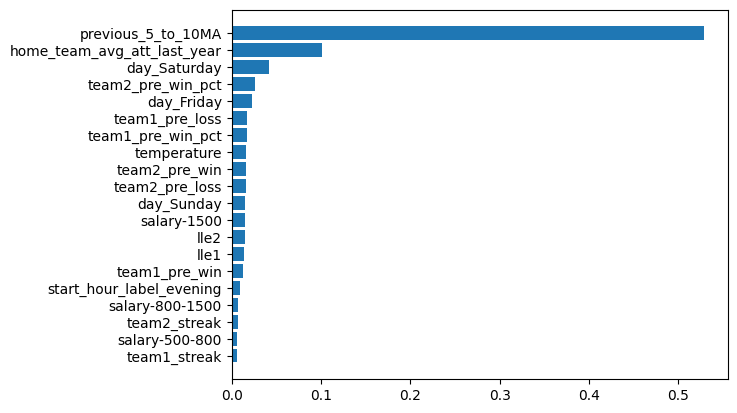

In [36]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in br.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(data_train.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

In [37]:
feature_importances[indices][::-1]

array([0.00611286, 0.00644066, 0.00686275, 0.00686543, 0.00982042,
       0.01271177, 0.01382974, 0.01439446, 0.01442922, 0.01528712,
       0.0156259 , 0.01649304, 0.01650234, 0.01664545, 0.01754714,
       0.02277009, 0.02650798, 0.04182286, 0.10075893, 0.52899448])

In [38]:
np.array(data_train.columns)[indices][::-1]

array(['team1_streak', 'salary-500-800', 'team2_streak',
       'salary-800-1500', 'start_hour_label_evening', 'team1_pre_win',
       'lle1', 'lle2', 'salary-1500', 'day_Sunday', 'team2_pre_loss',
       'team2_pre_win', 'temperature', 'team1_pre_win_pct',
       'team1_pre_loss', 'day_Friday', 'team2_pre_win_pct',
       'day_Saturday', 'home_team_avg_att_last_year',
       'previous_5_to_10MA'], dtype=object)

### Evaluate testing set

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = br.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 45738056.69995982
Test RMSE: 6762.99169746347
Test MAE: 5284.129565644172
Test MAPE: 0.264759078408899


### Save model

In [40]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/br_model_{time}.sav'
pickle.dump(br, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

## Gradient Boosting 

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
#  'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.8, 1], 
parameters = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'max_depth': [3, 5, 8, 10]}
model = GradientBoostingRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000,
                          random_state=42)
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,3.415899,0.043571,0.004604,4.906608e-04,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.606427e+07,-2.928223e+07,...,94.904200,36,-0.162196,-0.173083,-0.176772,-0.172936,-0.171568,-0.171311,0.004873,36
1,7.721404,0.110551,0.006406,4.901352e-04,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.246124e+07,-2.591666e+07,...,93.745941,35,-0.146205,-0.157004,-0.158335,-0.155291,-0.152686,-0.153904,0.004288,33
2,41.000385,0.310811,0.019018,1.096062e-03,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-1.844622e+07,-2.153309e+07,...,82.464205,25,-0.127874,-0.137476,-0.138072,-0.135746,-0.135196,-0.134873,0.003657,24
3,79.683469,1.449618,0.035032,5.135693e-07,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-1.706375e+07,-2.057050e+07,...,82.274990,19,-0.122677,-0.131503,-0.132979,-0.130523,-0.131340,-0.129804,0.003651,17
4,5.321226,0.090964,0.006206,4.000427e-04,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-2.152727e+07,-2.469707e+07,...,92.766786,30,-0.143318,-0.153402,-0.153739,-0.151715,-0.151196,-0.150674,0.003803,29


### Training with best params

In [57]:
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
gb = gb.fit(x_train, y_train)

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = gb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 577733.8368300097
Train RMSE: 760.0880454460587
Train MAE: 586.5720989565677
Train MAPE: 0.02310067577937645


Text(0.5, 0, 'Feature Importance')

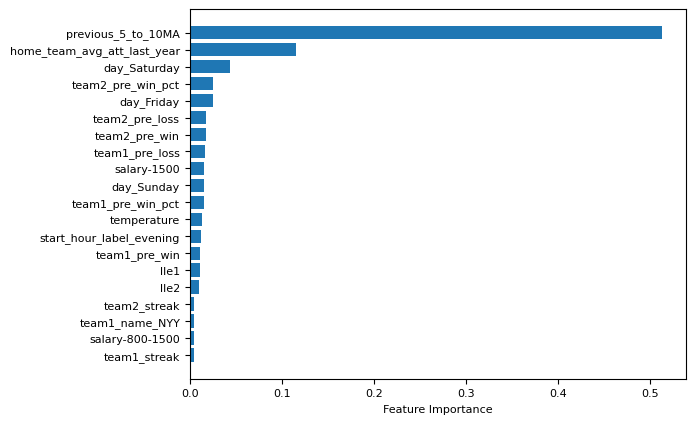

In [63]:
from matplotlib import pyplot as plt
num_features = 20
sorted_idx = gb.feature_importances_.argsort()[::-1][:num_features]
cols = data_train.columns
plt.barh(cols[sorted_idx][:num_features][::-1], gb.feature_importances_[sorted_idx][:num_features][::-1])
plt.xlabel("Feature Importance")

In [64]:
print(cols[sorted_idx][:num_features][::-1])

Index(['team1_streak', 'salary-800-1500', 'team1_name_NYY', 'team2_streak',
       'lle2', 'lle1', 'team1_pre_win', 'start_hour_label_evening',
       'temperature', 'team1_pre_win_pct', 'day_Sunday', 'salary-1500',
       'team1_pre_loss', 'team2_pre_win', 'team2_pre_loss', 'day_Friday',
       'team2_pre_win_pct', 'day_Saturday', 'home_team_avg_att_last_year',
       'previous_5_to_10MA'],
      dtype='object')


In [65]:
print(gb.feature_importances_[sorted_idx][:num_features][::-1])

[0.00425445 0.00434329 0.00477595 0.00491091 0.01003294 0.01062895
 0.0107345  0.01183163 0.01272416 0.01493756 0.01526867 0.0155052
 0.01627739 0.01752651 0.01762041 0.0252043  0.02542749 0.04333939
 0.11554059 0.5134604 ]


### Evaluate testing set

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = gb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 39944547.42656239
Test RMSE: 6320.169889058552
Test MAE: 4889.885616678008
Test MAPE: 0.2418806210983902


### Save Model

In [60]:
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/gradientboosting_model_{time}.sav'
pickle.dump(gb, open(filename, 'wb'))

## XGBoost

In [61]:
from xgboost import XGBRegressor

### Hyperparameters Tuning

In [13]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_estimators': [100, 300, 500, 1000], 'max_depth':[3, 5, 8, 10], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'colsample_bytree': [0.3, 0.7, 1]}
model = XGBRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7, 1],
                         'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 300, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [14]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [15]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,2.269679,0.089486,0.025791,0.002665,0.3,0.1,3,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.425527e+07,...,36.183440,116,-0.151206,-0.162221,-0.162909,-0.152774,-0.151575,-0.156137,0.005278,119
1,6.845363,0.249606,0.029762,0.002136,0.3,0.1,3,300,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.156413e+07,...,29.587957,96,-0.137124,-0.146534,-0.147467,-0.138006,-0.137893,-0.141405,0.004588,97
2,11.585741,0.335723,0.040869,0.004528,0.3,0.1,3,500,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.036101e+07,...,31.240256,83,-0.132052,-0.141476,-0.142775,-0.133560,-0.133338,-0.136640,0.004527,83
3,24.597726,0.572496,0.063271,0.015026,0.3,0.1,3,1000,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-1.903194e+07,...,22.256316,70,-0.127227,-0.137257,-0.136631,-0.128467,-0.128143,-0.131545,0.004431,68
4,3.666557,0.088281,0.033861,0.004056,0.3,0.1,5,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.103318e+07,...,36.522716,92,-0.136794,-0.145933,-0.147362,-0.138993,-0.137425,-0.141302,0.004446,95


### Train with best params

In [62]:
# colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
xgb = xgb.fit(x_train, y_train)

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = xgb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 1164218.112722959
Train RMSE: 1078.9893941661146
Train MAE: 784.3542271944402
Train MAPE: 0.03099388164798752


Text(0.5, 0, 'Xgboost Feature Importance')

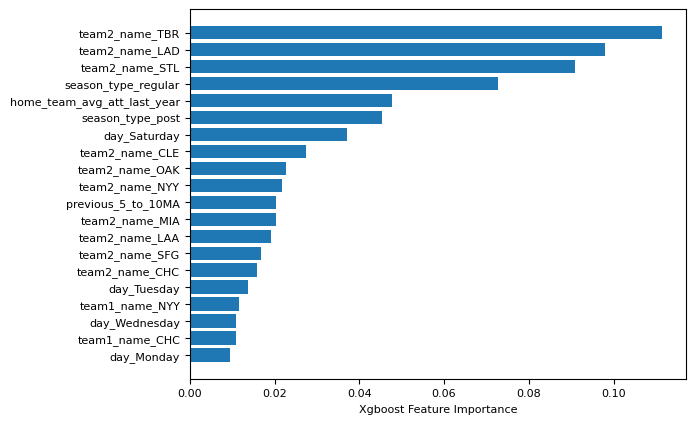

In [68]:
from matplotlib import pyplot as plt
sorted_idx = xgb.feature_importances_.argsort()[::-1]
cols = data_train.columns
plt.barh(cols[sorted_idx][:20][::-1], xgb.feature_importances_[sorted_idx][:20][::-1])
plt.xlabel("Xgboost Feature Importance")

In [69]:
xgb.feature_importances_[sorted_idx][:20][::-1]

array([0.00939998, 0.01086453, 0.01097509, 0.011674  , 0.01380076,
       0.0158119 , 0.01684907, 0.01904645, 0.02026382, 0.02037678,
       0.02169791, 0.0226647 , 0.02737366, 0.03710059, 0.04528563,
       0.04764755, 0.07279659, 0.09099059, 0.09788465, 0.11149874],
      dtype=float32)

In [70]:
cols[sorted_idx][:20][::-1]

Index(['day_Monday', 'team1_name_CHC', 'day_Wednesday', 'team1_name_NYY',
       'day_Tuesday', 'team2_name_CHC', 'team2_name_SFG', 'team2_name_LAA',
       'team2_name_MIA', 'previous_5_to_10MA', 'team2_name_NYY',
       'team2_name_OAK', 'team2_name_CLE', 'day_Saturday', 'season_type_post',
       'home_team_avg_att_last_year', 'season_type_regular', 'team2_name_STL',
       'team2_name_LAD', 'team2_name_TBR'],
      dtype='object')

### Testing set

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = xgb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 36048062.45205903
Test RMSE: 6004.003868424722
Test MAE: 4698.934744655867
Test MAPE: 0.24075038739240207


### Save model

In [72]:
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/xgboost_model_{time}.sav'
pickle.dump(xgb, open(filename, 'wb'))

## Note

整理上述結果，有什麼新發現

發現...

## Stacking

### List all models we selected

In [12]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
la = Lasso(max_iter=50000, alpha=1.438449888287663)
ri = Ridge(max_iter=50000, alpha=0.3359818286283781)
xgb_final = XGBRegressor(learning_rate=0.05, max_depth=8, n_estimators=100, random_state=42)

### Training

In [13]:
estimators = [
     ('Gradient Boosting', gb),
     ('XGBoost', xgb),
     ('Lasso', la),
     ('Ridge', ri),
]
sr = StackingRegressor(estimators=estimators, final_estimator=xgb_final, cv=5, n_jobs=-1, verbose=1)

In [14]:
sr.fit(x_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=8,
                                                         n_estimators=1000,
                                                         random_state=42)),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None...
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=8,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=42, ...),
                  n_jobs=-1, verbose=1)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = sr.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 1491312.7682465669
Train RMSE: 1221.1931740091602
Train MAE: 854.1221703564333
Train MAPE: 0.033570359494497645


### Evaluate testing set

In [21]:
y_pred = sr.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 37515508.27246533
Test RMSE: 6124.990471214248
Test MAE: 4732.491311189929
Test MAPE: 0.23313413670326869


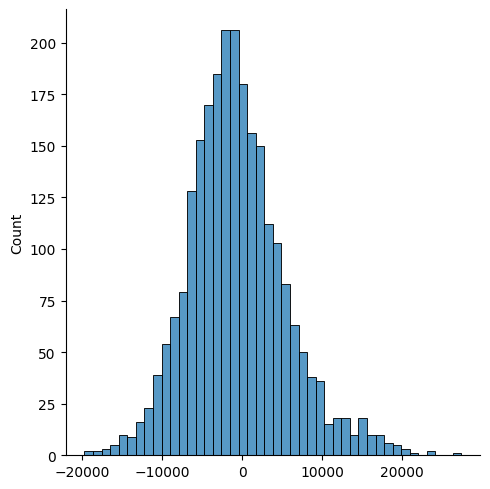

In [22]:
import seaborn as sns
sns.displot(y_test - y_pred)

Text(0, 0.5, 'Predicted Audience')

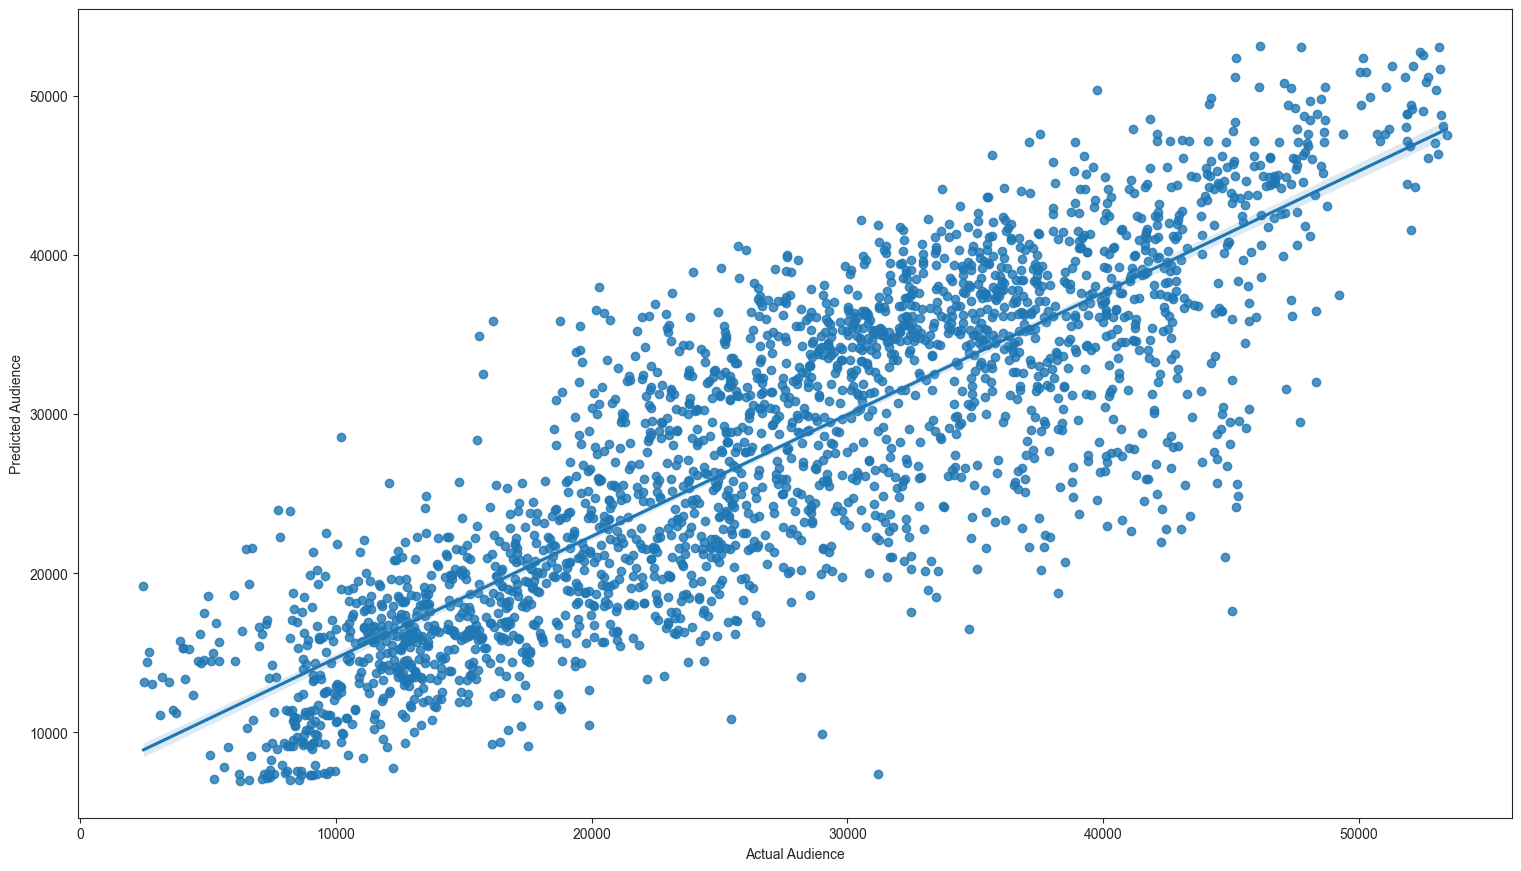

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.xlabel("Actual Audience")
plt.ylabel("Predicted Audience")

## Conclusion